In [1]:
import os
import sys

curr_path = !pwd
curr_path = curr_path[0] + "/"
curr_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/notebooks/'

In [2]:
utils_path = os.path.join(os.path.dirname(curr_path), '..', '..', 'utils/')
utils_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/notebooks/../../utils/'

In [3]:
sys.path.append(utils_path)

In [4]:
models_path = os.path.join(os.path.dirname(curr_path), '..', '..', '..', 'models', 'test_models/')
models_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/notebooks/../../../models/test_models/'

In [5]:
import torch
from ModelUtils import ModelUtils
from PruningHelper import PruningHelper as ph
from DataLoader import CelebADataset
from torch.utils.data import random_split, DataLoader, Subset

In [6]:
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
mu = ModelUtils(device)

### Data

In [8]:
data_path = os.path.join(os.path.dirname(curr_path), '..', '..', '..', 'dataset/')
img_path = os.path.join(os.path.dirname(data_path), 'Img', 'img_align_celeba')
anno_path = os.path.join(os.path.dirname(data_path), 'Anno', 'list_attr_celeba.txt')
img_path, anno_path

('/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/notebooks/../../../dataset/Img/img_align_celeba',
 '/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/notebooks/../../../dataset/Anno/list_attr_celeba.txt')

In [9]:
SAMPLE_SEED = 42
K_FOLDS = 4
EPOCHS = 1

BATCH_SIZE = 64

In [10]:
dataset = CelebADataset(img_path, anno_path)

In [11]:
TOTAL_SIZE = len(dataset)
TOTAL_SIZE

202599

In [12]:
SAMPLE_SIZE = 3000

In [13]:
test_size = int(0.1 * SAMPLE_SIZE)
train_size = int(SAMPLE_SIZE - test_size)

# Generator
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Data Sampling
sample_indices = torch.randperm(len(dataset))[:SAMPLE_SIZE]
ds_sample = Subset(dataset, sample_indices)
ds_train, ds_test = random_split(ds_sample, [train_size, test_size], generator=generator)
print(f"[Sampling] Train size: {len(ds_train)}, Test size: {len}")
# -----------End sampling ---------------

[Sampling] Train size: 2700, Test size: <built-in function len>


In [14]:
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

### Confirming models are loaded up properly

In [15]:
full_model = torch.load(f'{models_path}/full_model_04_06_2025_18_04.pth', weights_only=False)
pruned_model = torch.load(f'{models_path}/pruned_model_04_06_2025_18_04.pth', weights_only=False)

In [16]:
ph.get_sparsity(full_model), ph.get_sparsity(pruned_model)

(0.0, 89.99997671799692)

In [17]:
mu.test_model(full_model, test_loader)

Test Evaluation
Accuracy: 0.61
Test precision: 0.25
Test recall: 0.97
Test f1-score: 0.40
Finished test evaluation!


In [18]:
mu.test_model(pruned_model, test_loader)

Test Evaluation
Accuracy: 0.92
Test precision: 0.77
Test recall: 0.51
Test f1-score: 0.62
Finished test evaluation!


In [19]:
test_cie = mu.get_cie_count(full_model, pruned_model, test_loader)

Determining CIEs:
Number of CIEs: 127


In [ ]:
train_cie = mu.get_cie_count(full_model, pruned_model, train_loader)

In [ ]:
print(f"The total number of CIEs is: {len(test_cie) + len(train_cie)}")

### CIE EDA

Young: 91, Old: 36, Females: 70, Males: 57


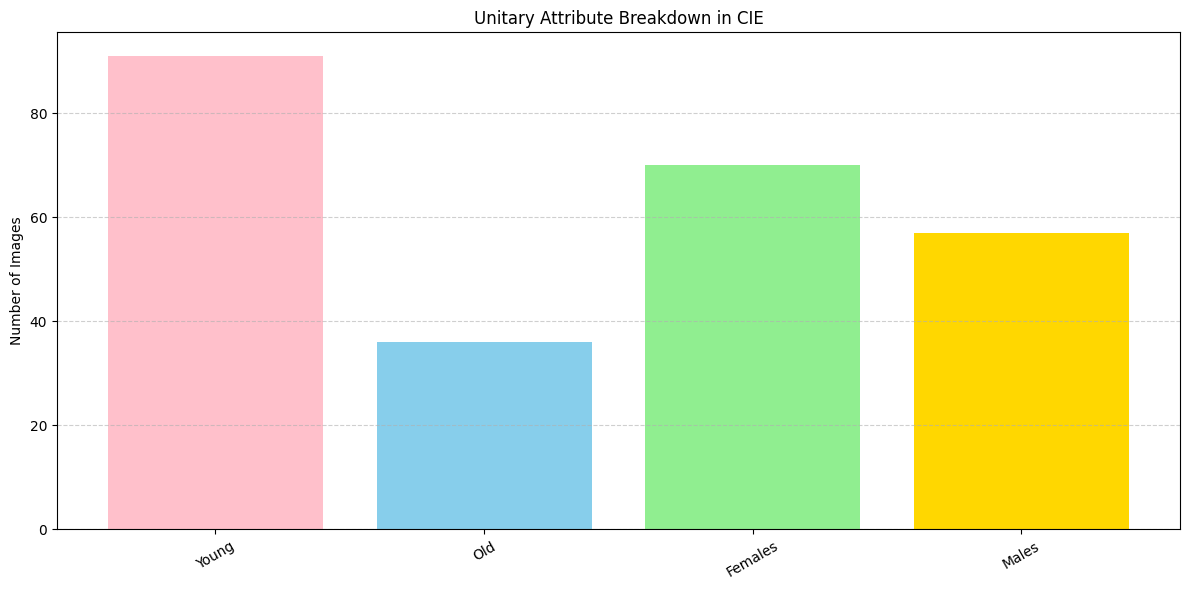

In [22]:
mu.show_cie_eda_unitary_plot(test_cie, anno_path)

Young Females: 54, Young Males: 37, Old Males: 20, Old Females: 16


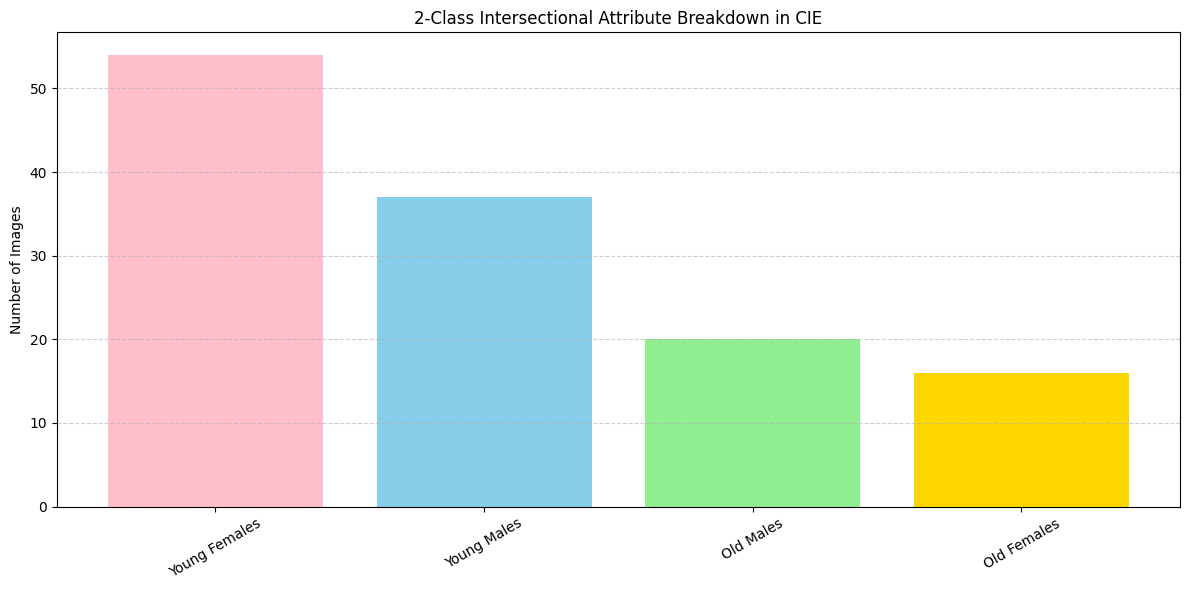

In [23]:
mu.show_cie_eda_inter_plot(test_cie, anno_path)

Non-Blonde Young: NBY
Non-Blonde Female: NBF
Non-Blonde Male: NBM
Non-Blonde Old: NBO
Blonde Female: BF
Blonde Young: BY
Blonde Old: BO
Blonde Male: BM
NBY: 79, NBF: 53, NBM: 56, NBO: 30, BF: 17, BY: 12, BO: 6, BM: 1


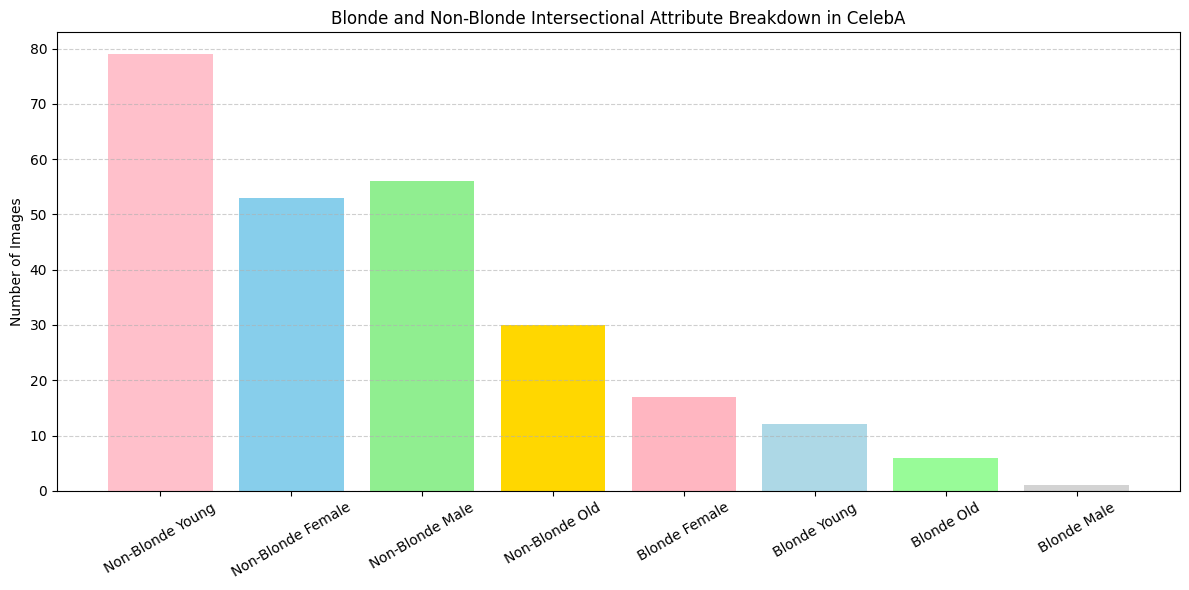

In [24]:
mu.show_cie_eda_blonde_inter_plot(test_cie, anno_path)